In [ ]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.linear_model
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
import sklearn.decomposition
import requests
import seaborn as sns
import scipy.stats
import math
import datetime

from matplotlib import pyplot as plt

In [ ]:
!pip install yfinance patsy
import yfinance as yf

## Задание 1

### Графики

In [ ]:
column_mapping = {
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}
ea = yf.download('EA', '2015-12-05', '2020-12-05').rename(columns=column_mapping).drop(columns=['Adj Close'])
atvi = yf.download('ATVI', '2015-12-05', '2020-12-05').rename(columns=column_mapping).drop(columns=['Adj Close'])
ttwo = yf.download('TTWO', '2015-12-05', '2020-12-05').rename(columns=column_mapping).drop(columns=['Adj Close'])
znga = yf.download('ZNGA', '2015-12-05', '2020-12-05').rename(columns=column_mapping).drop(columns=['Adj Close'])
stonks = {
    'ea': ea,
    'atvi': atvi,
    'ttwo': ttwo,
    'znga': znga
}
znga.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2015-12-07,2.62,2.66,2.58,2.61,4814900
2015-12-08,2.60,2.64,2.57,2.60,7288200
2015-12-09,2.60,2.62,2.50,2.55,8382800
2015-12-10,2.54,2.61,2.54,2.57,4518500
2015-12-11,2.55,2.59,2.44,2.46,9585400


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

1) Графики стоимостей акций на начало каждого дня

In [ ]:
def plot_feature(company_stonks, feature_name, rolling_mean=None):
    fig = go.Figure()
    for name, data in company_stonks.items():
        d = data[feature_name].rolling(rolling_mean).mean() if rolling_mean else data[feature_name]
        fig.add_trace(go.Scatter(x=data.index, y=d, name=name))
    fig.show()

In [ ]:
plot_feature(stonks, 'open')

2) отразите на графике объёмы торгов за каждый день. Прокомментируйте
полученные графики: определите, какие события могли повлиять на повышение
объёма (отчёт компании, кризис и т. п.)

In [ ]:
plot_feature(stonks, 'volume')

In [ ]:
plot_feature(stonks, 'volume', rolling_mean=15)

4) определите, цены каких компаний наиболее и наименее скоррелированы

In [ ]:
all = None
for name, data in stonks.items():
    columns_prefixed = {column: f'{name}_{column}'for column in ea.columns}
    if all is None:
        all = data.rename(columns=columns_prefixed)
    else:
        all = all.join(data.rename(columns=columns_prefixed))
all

,ea_open,ea_high,ea_low,ea_close,ea_volume,atvi_open,atvi_high,atvi_low,atvi_close,atvi_volume,ttwo_open,ttwo_high,ttwo_low,ttwo_close,ttwo_volume,znga_open,znga_high,znga_low,znga_close,znga_volume
Date,,,,,,,,,,,,,,,,,,,,
2015-12-07,70.739998,71.940002,70.349998,70.790001,3654800,38.919998,39.029999,38.389999,38.689999,6738400,36.529999,36.580002,35.970001,36.110001,807800,2.62,2.66,2.58,2.61,4814900
2015-12-08,70.400002,71.169998,69.949997,70.989998,4446600,38.330002,39.459999,38.130001,39.360001,5634200,35.669998,36.349998,35.599998,36.250000,579600,2.60,2.64,2.57,2.60,7288200
2015-12-09,70.750000,70.989998,66.620003,67.089996,8308200,39.200001,39.349998,37.860001,38.590000,7247800,36.160000,36.330002,35.360001,35.590000,1027500,2.60,2.62,2.50,2.55,8382800
2015-12-10,67.510002,67.889999,66.080002,66.370003,3396400,38.709999,38.820000,38.080002,38.380001,5210000,35.529999,35.799999,35.099998,35.419998,814400,2.54,2.61,2.54,2.57,4518500
2015-12-11,67.489998,69.650002,66.709999,67.169998,6058300,37.759998,38.259998,36.759998,37.220001,10795300,34.759998,35.459999,34.660000,35.009998,1939500,2.55,2.59,2.44,2.46,9585400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30,124.769997,128.399994,123.269997,127.750000,10085200,78.320000,79.730003,77.779999,79.480003,15235000,176.779999,181.710007,175.139999,180.509995,2667000,8.25,8.34,8.07,8.25,17220000
2020-12-01,127.580002,128.000000,125.660004,127.239998,2827900,79.940002,79.989998,78.629997,79.930000,5795800,181.500000,181.500000,175.250000,180.059998,1151200,8.20,8.28,8.09,8.24,12741700
2020-12-02,127.029999,129.750000,126.480003,129.539993,1905700,79.720001,80.010002,78.739998,79.150002,4780600,178.949997,181.479996,177.789993,181.300003,703000,8.15,8.39,8.12,8.32,16373300


In [ ]:
fig = go.Figure(data=go.Heatmap(
                   z=all.corr(),
                   x=all.columns,
                   y=all.columns))
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    autosize=False,
    width=800,
    height=600
)
fig.show()

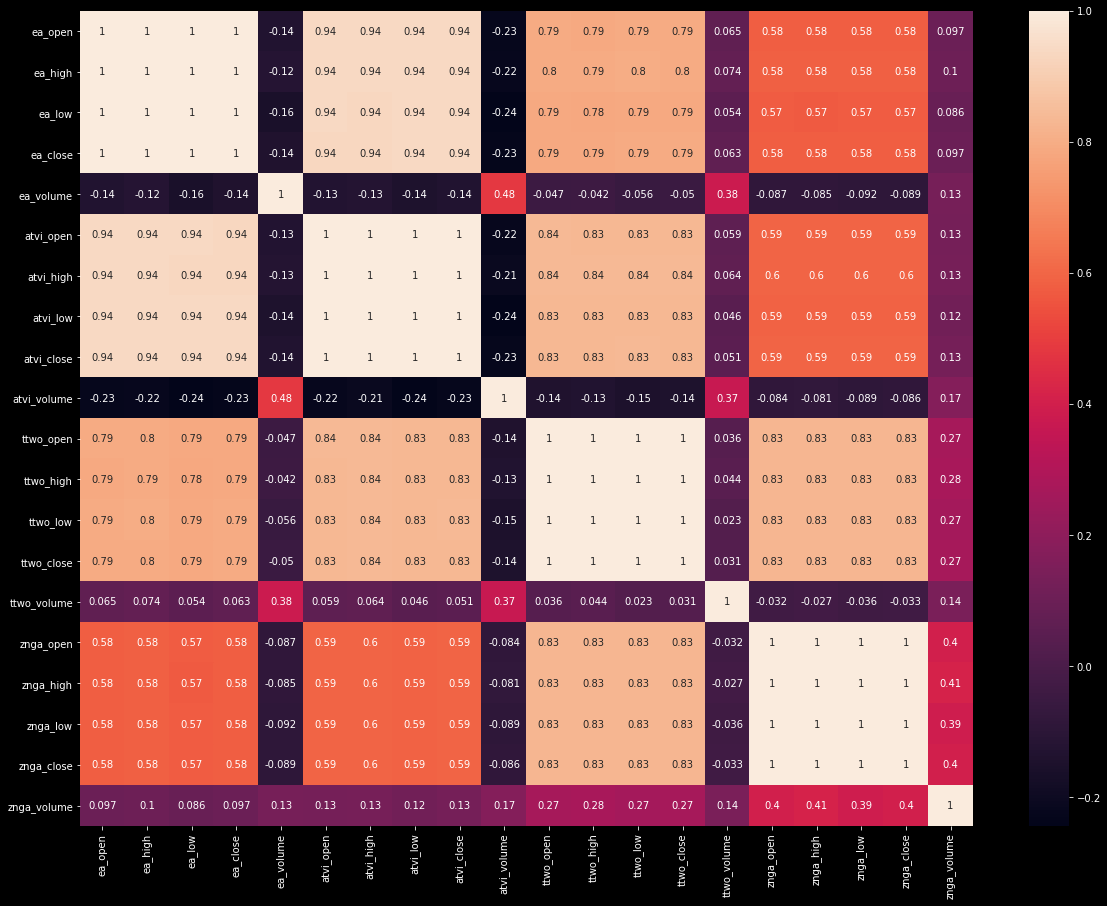

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(all.corr(), annot=True)

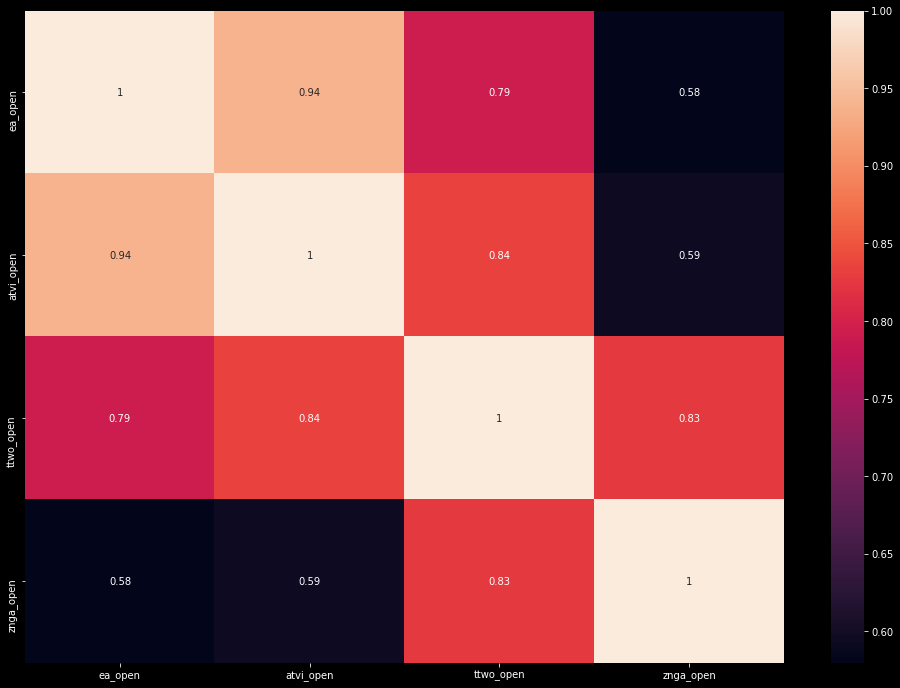

In [ ]:
all = all[[column for column in all.columns if column.endswith('open')]]
plt.figure(figsize=(17, 12))
sns.heatmap(all.corr(), annot=True)

In [ ]:
X, y = all.copy(), ea['close']
print(X.head())
print(y.head())

              ea_open  atvi_open  ttwo_open  znga_open
Date                                                  
2015-12-07  70.739998  38.919998  36.529999       2.62
2015-12-08  70.400002  38.330002  35.669998       2.60
2015-12-09  70.750000  39.200001  36.160000       2.60
2015-12-10  67.510002  38.709999  35.529999       2.54
2015-12-11  67.489998  37.759998  34.759998       2.55
Date
2015-12-07    70.790001
2015-12-08    70.989998
2015-12-09    67.089996
2015-12-10    66.370003
2015-12-11    67.169998
Name: close, dtype: float64


## Задание 2

### Линейная регрессия обычная


In [ ]:
df = X
df['atvi_open_-7'] = df.atvi_open.shift(-7)
df['ttwo_open_-7'] = df.ttwo_open.shift(-7)
df['znga_open_-7'] = df.znga_open.shift(-7)
df = df.dropna(axis=0)

X_my, y_my= df[['atvi_open_-7', 'ttwo_open_-7', 'znga_open_-7']], df['ea_open']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_my, y_my, shuffle = False, test_size=0.2)
myModel = sklearn.linear_model.LinearRegression() 
myModel.fit(X_train,y_train)

print('On train MSE: ', mean_squared_error(y_train, myModel.predict(X_train)))
print('On test MSE: ', mean_squared_error(y_test, myModel.predict(X_test)))
print('On train r2: ', r2_score(y_train, myModel.predict(X_train)))
print('On test r2: ', r2_score(y_test, myModel.predict(X_test)))

On train MSE:  53.312279000003386
On test MSE:  395.0149212925999
On train r2:  0.8745547467574688
On test r2:  -1.0506985014672408


### Линейная регрессия накопительная

In [ ]:
def add_history(x, y, days_count):
    with_history = x
    for i in range(1, days_count):
        with_history = with_history.join(x.shift(i), rsuffix=f'_-{i}')
    with_history = with_history.dropna()
    return with_history, y.loc[with_history.index]
X, y = add_history(X, y, 5)

In [ ]:
def train_test_linear_model(X, y, random_state=42, test_days_count=100, test_size=0.2, with_baseline=False):
    print('Splitting randomly:')
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    print('On train: ', sklearn.metrics.mean_squared_error(y_train, model.predict(X_train)))
    print('On test: ', sklearn.metrics.mean_squared_error(y_test, model.predict(X_test)))
    if with_baseline:
        baseline_model = lambda x: x['ea_open']
        print('On baseline: ', sklearn.metrics.mean_squared_error(y_test, baseline_model(X_test)))

    print('\nSplitting sequentially')
    X_train, X_test, y_train, y_test = X[:-100], X[-100:], y[:-100], y[-100:]
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    print('On train: ', sklearn.metrics.mean_squared_error(y_train, model.predict(X_train)))
    print('On test: ', sklearn.metrics.mean_squared_error(y_test, model.predict(X_test)))
    if with_baseline:
        print('On baseline: ', sklearn.metrics.mean_squared_error(y_test, baseline_model(X_test)))

In [ ]:
train_test_linear_model(X, y, with_baseline=True)

Splitting randomly:
On train:  2.3647405067661964
On test:  2.5515611825311018
On baseline:  2.4809475298833568

Splitting sequentially
On train:  2.2512185834391456
On test:  3.9480020419705255
On baseline:  4.098713341277326


In [ ]:
X, y = all.copy(), ea['close']

In [ ]:
def train_test_linear_model_scaled(X, y, x_scaler, y_scaler, random_state=42, test_days_count=100, test_size=0.2, with_baseline=False):
    print('Splitting randomly:')
    X = x_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    print('On train: ', sklearn.metrics.mean_squared_error(y_scaler.inverse_transform(y_train), y_scaler.inverse_transform(model.predict(X_train))))
    print('On test: ', sklearn.metrics.mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(model.predict(X_test))))
    if with_baseline:
        baseline_model = lambda x: x['ea_open']
        print('On baseline: ', sklearn.metrics.mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(baseline_model(X_test))))

    print('\nSplitting sequentially')
    X_train, X_test, y_train, y_test = X[:-100], X[-100:], y[:-100], y[-100:]
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    print('On train: ', sklearn.metrics.mean_squared_error(y_scaler.inverse_transform(y_train), y_scaler.inverse_transform(model.predict(X_train))))
    print('On test: ', sklearn.metrics.mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(model.predict(X_test))))
    if with_baseline:
        print('On baseline: ', sklearn.metrics.mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(baseline_model(X_test))))

In [ ]:
x_scaler = sklearn.preprocessing.StandardScaler()
y_scaler = sklearn.preprocessing.StandardScaler()
X_with_history, y_with_history = add_history(X, y, 5)
train_test_linear_model_scaled(X_with_history, y_with_history, x_scaler, y_scaler)

Splitting randomly:
On train:  2.8422666512243793
On test:  2.342169940246101

Splitting sequentially
On train:  2.615411881756366
On test:  4.4811741100062665


## Задание 3

### Метод главных компонент

In [ ]:
pca = sklearn.decomposition.PCA(n_components=13)
decomposed = pca.fit_transform(X_with_history)
print('Explained variace: ', pca.explained_variance_ratio_)
print('N components: ', pca.n_components_)
train_test_linear_model_scaled(decomposed, y_with_history, x_scaler, y_scaler)

Explained variace:  [9.12186933e-01 7.62657180e-02 7.12429413e-03 1.71286061e-03
 5.86173943e-04 5.56852961e-04 4.54953340e-04 3.40439732e-04
 2.69242307e-04 1.47756717e-04 1.26647949e-04 7.34388440e-05
 5.71640444e-05]
N components:  13
Splitting randomly:
On train:  2.9011223885498683
On test:  2.32348216888594

Splitting sequentially
On train:  2.688060976392684
On test:  4.013606446957283


### Разбиение приращений по группам

In [ ]:
all = None
for name, data in stonks.items():
    columns_prefixed = {column: f'{name}_{column}'for column in ea.columns}
    if all is None:
        all = data.rename(columns=columns_prefixed)
    else:
        all = all.join(data.rename(columns=columns_prefixed))

In [ ]:
for company in stonks.keys():
    all[f'{company}_growth_rate'] = all[f'{company}_close'] / all[f'{company}_close'].shift(1)
all = all.replace(np.nan, 1)

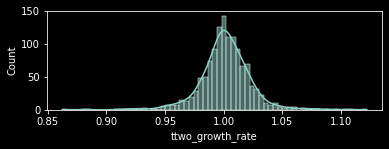

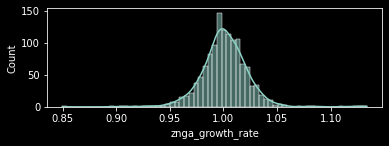

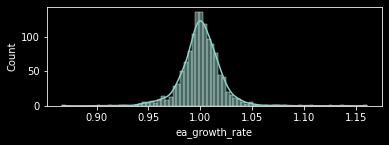

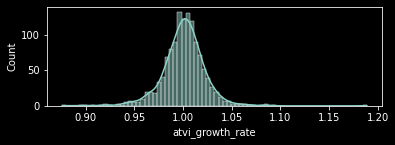

In [ ]:
ax = plt.subplot(211)
sns_plot = sns.histplot(all['ttwo_growth_rate'], kde=True)
fig = sns_plot.get_figure()
plt.show()
ax = plt.subplot(212)
sns_plot = sns.histplot(all['znga_growth_rate'], kde=True)
fig = sns_plot.get_figure()
plt.show()
ax = plt.subplot(212)
sns_plot = sns.histplot(all['ea_growth_rate'], kde=True)
fig = sns_plot.get_figure()
plt.show()
ax = plt.subplot(212)
sns_plot = sns.histplot(all['atvi_growth_rate'], kde=True)
fig = sns_plot.get_figure()
plt.show()

In [ ]:
def group_uniformaly(stonk_growth_rate, groups_num):
    elements_per_group = int(stonk_growth_rate.shape[0] // groups_num)
    elements_left = int(stonk_growth_rate.shape[0] % groups_num)
    groups = []
    stonk_growth_rate = stonk_growth_rate.sort_values()
    next_group_start_index = 0
    while next_group_start_index < stonk_growth_rate.shape[0]:
        if elements_left == 0:
            elements_for_this_group = elements_per_group
        else:
            elements_left -= 1
            elements_for_this_group = elements_per_group + 1
        groups.append(stonk_growth_rate[next_group_start_index:next_group_start_index + elements_for_this_group])
        next_group_start_index += elements_for_this_group
    return groups

In [ ]:
groups_num = round(1 + 3.322*math.log(len(all)))
group_bounds = dict()
for company_name in stonks.keys():
    groups = group_uniformaly(all[f'{company_name}_growth_rate'], groups_num)
    group_bounds[company_name] = {i + 1: (group_values.min(), group_values.max()) for i, group_values in enumerate(groups)}
    group_values = pd.concat([group_values.apply(lambda x: i + 1) for i, group_values in enumerate(groups)])\
        .sort_index()
    all[f'{company_name}_growth_rate_group'] = group_values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88b3c733c8>,
      dtype=object)

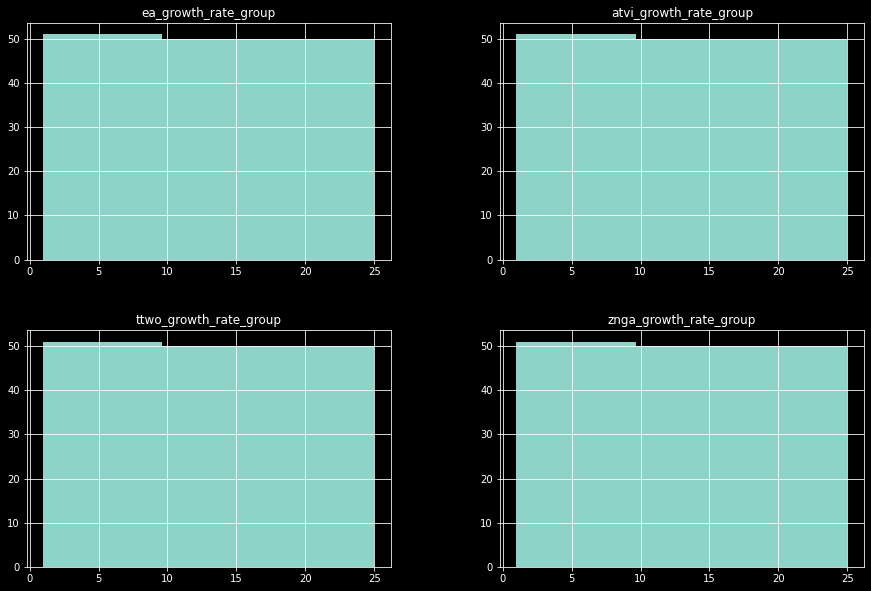

In [ ]:
all[[f'{company}_growth_rate_group' for company in stonks.keys()]].hist(bins=groups_num, figsize=(15, 10))

### Случайный лес по группам

In [ ]:
def groups_to_abs_values(groups_array, previous_value, company_name):
    growth_rates = np.empty(groups_array.shape)
    for i, group in enumerate(groups_array):
        bounds = group_bounds[company_name][group]
        growth_rates[i] = (bounds[0] + bounds[1]) / 2

    abs_value = np.empty(growth_rates.shape)
    for i, growth_rate in enumerate(growth_rates):
        abs_value[i] = previous_value * growth_rate
        previous_value = abs_value[i]
    return abs_value

In [ ]:
def train_test_plot_clf(model, all_dataset, company_name, days_history, days_for_test):
    stonk_groups = all_dataset[[f'{company_name}_growth_rate_group']].copy()
    company_groups_with_history = stonk_groups
    for i in range(1, days_history + 1):
        company_groups_with_history = company_groups_with_history.join(stonk_groups.shift(i), rsuffix=f'_-{i}')
    company_groups_with_history.dropna(inplace=True)
    X, y = company_groups_with_history.iloc[:, 1:], company_groups_with_history.iloc[:, 0]
    X_train, X_test, y_train, y_test = X.iloc[:-days_for_test], X.iloc[-days_for_test:], y.iloc[:-days_for_test], y.iloc[-days_for_test:]
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    print('If try to predict by real previous class')
    print('Logloss: ', sklearn.metrics.log_loss(y_test, y_pred_proba))
    print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, y_pred))
    print('MSE: ', sklearn.metrics.mean_squared_error(y_test, y_pred))

    print('If try to predict by predicted previous class')
    y_pred = np.empty((days_for_test,))
    y_pred_proba = np.empty((days_for_test, groups_num))
    prev_history = X_train.iloc[-1]
    for i in range(days_for_test):
        y_pred_proba[i] = model.predict_proba(prev_history.values.reshape(1, -1)).reshape(-1)
        y_pred[i] = y_pred_proba[i].argmax() + 1
        prev_history = prev_history.shift().fillna(y_pred[i])
    print('Logloss: ', sklearn.metrics.log_loss(y_test, y_pred_proba))
    print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, y_pred))
    print('MSE: ', sklearn.metrics.mean_squared_error(y_test, y_pred))

    X_test_first_date = X_test.iloc[0].name
    previous_value = all_dataset.loc[X_test_first_date, f'{company}_close'].squeeze()    
    y_pred_abs_value = groups_to_abs_values(y_pred, previous_value, company_name)
    y_test_abs_value = all_dataset.iloc[-days_for_test:][f'{company}_close']
    print('MSE by absolute value: ', sklearn.metrics.mean_squared_error(y_test_abs_value, y_pred_abs_value))

    y_train_abs = all_dataset.loc[:X_test_first_date, f'{company}_close']
    y_test_abs = all_dataset.loc[X_test_first_date:, f'{company}_close'] 

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_train_abs.index, y=y_train_abs, name='Train'))
    fig.add_trace(go.Scatter(x=y_test_abs.index, y=y_test_abs, name='Test'))
    fig.add_trace(go.Scatter(x=y_test_abs.index, y=y_pred_abs_value, name='Random-Forest'))
    fig.show()

In [ ]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', random_state=42)
train_test_plot_clf(model, all, 'ttwo', 30, 180)

If try to predict by real previous class
Logloss:  3.364157695571392
Accuracy:  0.03888888888888889
MSE:  112.36666666666666
If try to predict by predicted previous class
Logloss:  3.392076930105835
Accuracy:  0.05555555555555555
MSE:  118.77222222222223
MSE by absolute value:  3.559454008454577


### Holt-Winters model

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

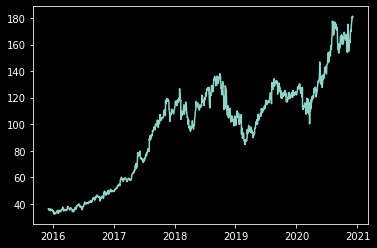

In [ ]:
plt.plot(ttwo.close)

In [ ]:
ttwo_share = pd.DataFrame(ttwo.low).asfreq('D')
ttwo_share['low'].ffill(inplace=True)
ea_share = pd.DataFrame(ea.low).asfreq('D')
ea_share['low'].ffill(inplace=True)
znga_share = pd.DataFrame(znga.low).asfreq('D')
znga_share['low'].ffill(inplace=True)
atvi_share = pd.DataFrame(atvi.low).asfreq('D')
atvi_share['low'].ffill(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

the 'damped'' keyword is deprecated, use 'damped_trend' instead

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning:

Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.



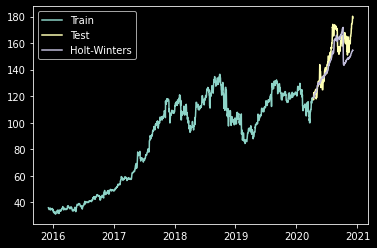

In [ ]:
plt.style.use('dark_background')
train, test = ttwo_share.iloc[:1587, 0], ttwo_share.iloc[1588:, 0]

model = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=589, damped=False)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=True)
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

the 'damped'' keyword is deprecated, use 'damped_trend' instead

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning:

Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



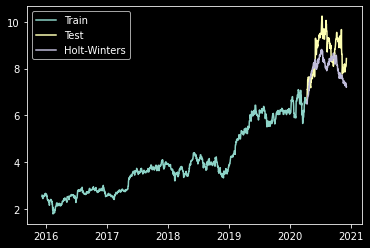

In [ ]:
train, test = znga_share.iloc[:1587, 0], znga_share.iloc[1588:, 0]

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=360, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=True)
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

the 'damped'' keyword is deprecated, use 'damped_trend' instead

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning:

Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



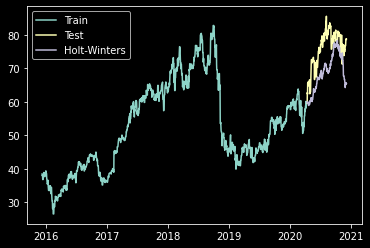

In [ ]:
train, test = atvi_share.iloc[:1587, 0], atvi_share.iloc[1588:, 0]

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=369, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=True)
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

the 'damped'' keyword is deprecated, use 'damped_trend' instead

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning:

Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



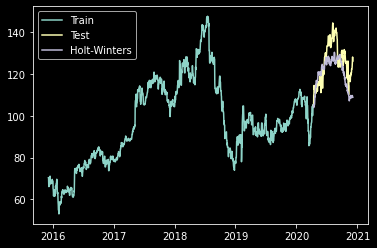

In [ ]:
train, test = ea_share.iloc[:1587, 0], ea_share.iloc[1588:, 0]

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=360, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=True)
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

### ARIMA

In [ ]:
! pip install statsmodels==0.12.1

In [ ]:
combs = {}
best_aic = 6183.615430193693
aics = [6183.615430193693]
#combs[best_aic] = (6,1,2)
combs[best_aic] = (6,1,7)

In [ ]:
ea_close = ea['close']
ea_close.index = pd.DatetimeIndex(ea_close.index).to_period('D')
#ea_close = ea_close.resample('D').last()
ea_close = ea_close.resample('D').sum()
ea_close.fillna(method='ffill', inplace=True)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import datetime

best_aic = min(aics)
model = ARIMA(ea_close[:-30], order=combs[best_aic]).fit()

print(model.summary())

y_pred = model.forecast(steps=30)
mse = mean_squared_error(ea_close[-30:], y_pred)
print('MSE:', mse)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1795
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -7719.060
Date:                Sat, 12 Dec 2020   AIC                          15466.119
Time:                        10:11:59   BIC                          15543.010
Sample:                    12-07-2015   HQIC                         15494.508
                         - 11-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9356      0.037    -25.067      0.000      -1.009      -0.862
ar.L2         -0.9547      0.009   -101.055      0.000      -0.973      -0.936
ar.L3         -0.9798      0.031    -31.828      0.0

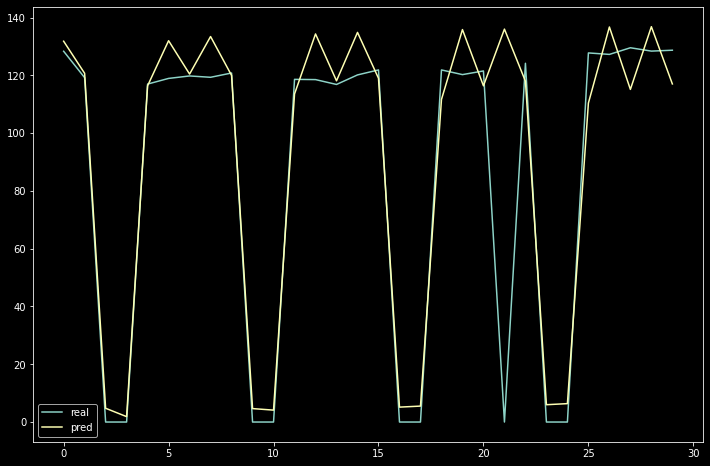

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(30), ea_close[-30:] , label='real')
plt.plot(range(30), y_pred, label='pred')


plt.legend();

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1795
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -6675.596
Date:                Sat, 12 Dec 2020   AIC                          13379.193
Time:                        10:12:06   BIC                          13456.083
Sample:                    12-07-2015   HQIC                         13407.581
                         - 11-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9124      0.050    -18.161      0.000      -1.011      -0.814
ar.L2         -0.9520      0.012    -81.383      0.000      -0.975      -0.929
ar.L3         -0.9625      0.042    -22.764      0.0

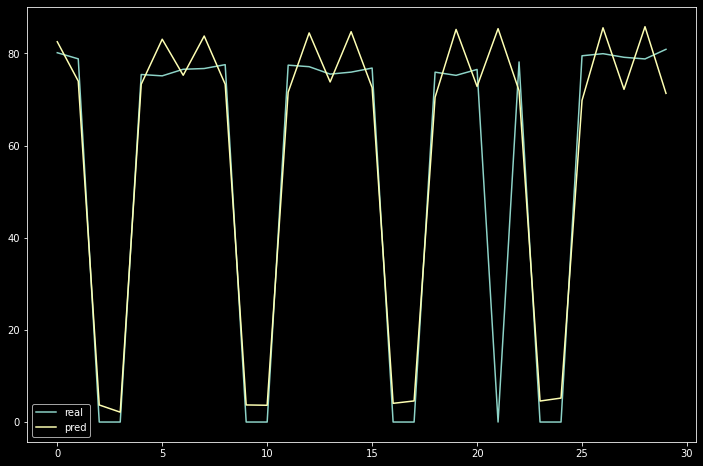

In [ ]:
atvi_close = atvi['close']
atvi_close.index = pd.DatetimeIndex(atvi_close.index).to_period('D')
#atvi_close = atvi_close.resample('D').last()
atvi_close = atvi_close.resample('D').sum()
atvi_close.fillna(method='ffill', inplace=True)

best_aic = min(aics)
model = ARIMA(atvi_close[:-30], order=combs[best_aic]).fit()

print(model.summary())

y_pred = model.forecast(steps=30)
mse = mean_squared_error(atvi_close[-30:], y_pred)
print('MSE:', mse)

plt.figure(figsize=(12, 8))
plt.plot(range(30), atvi_close[-30:] , label='real')
plt.plot(range(30), y_pred, label='pred')


plt.legend();

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1795
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -7713.903
Date:                Sat, 12 Dec 2020   AIC                          15455.805
Time:                        10:12:12   BIC                          15532.696
Sample:                    12-07-2015   HQIC                         15484.194
                         - 11-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9447      0.034    -27.824      0.000      -1.011      -0.878
ar.L2         -0.9396      0.009    -98.941      0.000      -0.958      -0.921
ar.L3         -0.9990      0.027    -37.135      0.0

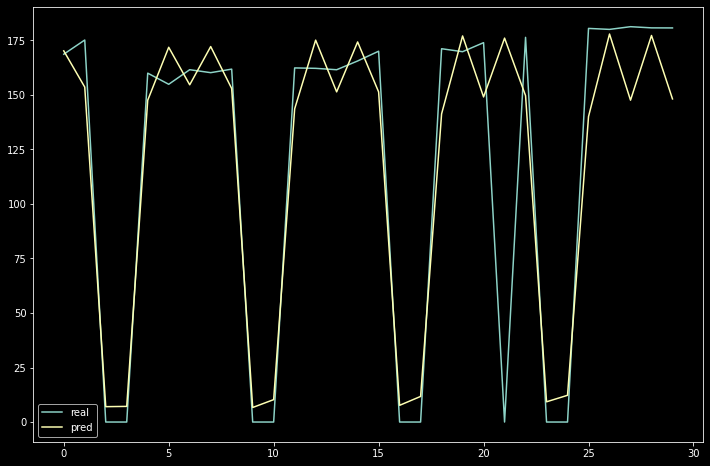

In [ ]:
ttwo_close = ttwo['close']
ttwo_close.index = pd.DatetimeIndex(ttwo_close.index).to_period('D')
#ttwo_close = ttwo_close.resample('D').last()
ttwo_close = ttwo_close.resample('D').sum()
ttwo_close.fillna(method='ffill', inplace=True)

best_aic = min(aics)
model = ARIMA(ttwo_close[:-30], order=combs[best_aic]).fit()

print(model.summary())

y_pred = model.forecast(steps=30)
mse = mean_squared_error(ttwo_close[-30:], y_pred)
print('MSE:', mse)

plt.figure(figsize=(12, 8))
plt.plot(range(30), ttwo_close[-30:] , label='real')
plt.plot(range(30), y_pred, label='pred')


plt.legend();

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1795
Model:                ARIMA(6, 1, 12)   Log Likelihood               -2338.032
Date:                Sat, 12 Dec 2020   AIC                           4714.063
Time:                        10:12:23   BIC                           4818.415
Sample:                    12-07-2015   HQIC                          4752.590
                         - 11-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0950      0.032    -34.164      0.000      -1.158      -1.032
ar.L2         -0.8494      0.010    -88.564      0.000      -0.868      -0.831
ar.L3         -1.1899      0.022    -52.901      0.0

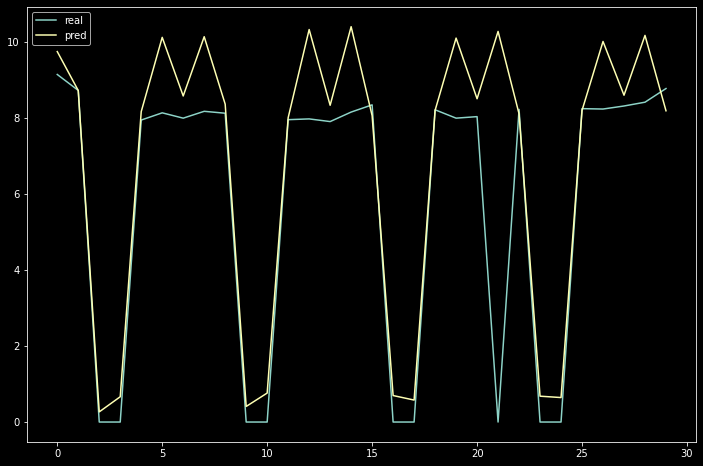

In [ ]:
combs[best_aic] = (6,1,12)

znga_close = znga['close']
znga_close.index = pd.DatetimeIndex(znga_close.index).to_period('D')
#znga_close = znga_close.resample('D').last()
znga_close = znga_close.resample('D').sum()
znga_close.fillna(method='ffill', inplace=True)

best_aic = min(aics)
model = ARIMA(znga_close[:-30], order=combs[best_aic]).fit()

print(model.summary())

y_pred = model.forecast(steps=30)
mse = mean_squared_error(znga_close[-30:], y_pred)
print('MSE:', mse)

plt.figure(figsize=(12, 8))
plt.plot(range(30), znga_close[-30:] , label='real')
plt.plot(range(30), y_pred, label='pred')


plt.legend();